In [53]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import time
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
import shap
import numpy as np
import pickle

data = pd.read_pickle("dataframe.pkl")

In [54]:
X = data.drop(["TotalGHGEmissions","SiteEnergyUse(kBtu)"], axis=1)
Y1 = data["TotalGHGEmissions"]
Y2 = data["SiteEnergyUse(kBtu)"]

In [55]:
X = X.astype({col: 'int64' for col in X.select_dtypes(include=['int32']).columns})

In [56]:
X = pd.get_dummies(X)

In [57]:
num_cols = X.select_dtypes(include=['float64','int64']).columns
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

X = X.astype(float)

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, Y1, test_size=0.2, random_state=42)

In [59]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

def rmse_cv(model,X,y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5)).mean()
    return rmse

def evaluation(y, predictions):
    mae = mean_absolute_error(y, predictions)
    mse = mean_squared_error(y, predictions)
    rmse = np.sqrt(mean_squared_error(y, predictions))
    r_squared = r2_score(y, predictions)
    return mae, mse, rmse, r_squared

In [60]:
models = pd.DataFrame(columns=["Model","MAE","MSE","RMSE","R2 Score","RMSE (Cross-Validation)", "Training Time (s)"])

In [61]:
alpha_values = {'alpha': [0.1, 1.0, 10.0, 50.0, 100.0]}
ridge = Ridge()

start_time = time.time()
grid_search = GridSearchCV(estimator=ridge, param_grid=alpha_values, scoring='neg_mean_squared_error', cv=3)
grid_search.fit(X_train, y_train)
ridge_train_time = time.time() - start_time
print(f"Temps d'entraînement Ridge: {ridge_train_time:.4f} secondes")


best_alpha = grid_search.best_params_['alpha']
print(f"Meilleure valeur de alpha: {best_alpha}")

best_ridge_model = grid_search.best_estimator_

train_pred = best_ridge_model.predict(X_train)

mae, mse, rmse, r_squared = evaluation(y_train, train_pred)
rmse_cross_val = rmse_cv(ridge,X_train,y_train)
new_row = {"Model": "Ridge_train","MAE": mae, "MSE": mse, "RMSE": rmse, "R2 Score": r_squared, "RMSE (Cross-Validation)": rmse_cross_val, "Training Time (s)": ridge_train_time}
models = models._append(new_row, ignore_index=True)

predictions = best_ridge_model.predict(X_test)

mae, mse, rmse, r_squared = evaluation(y_test, predictions)
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r_squared)
print("-"*30)
rmse_cross_val = rmse_cv(ridge,X_train,y_train)
print("RMSE Cross-Validation:", rmse_cross_val)

new_row = {"Model": "Ridge","MAE": mae, "MSE": mse, "RMSE": rmse, "R2 Score": r_squared, "RMSE (Cross-Validation)": rmse_cross_val, "Training Time (s)": ridge_train_time}
models = models._append(new_row, ignore_index=True)

Temps d'entraînement Ridge: 0.0506 secondes
Meilleure valeur de alpha: 1.0
MAE: 145.82038991612217
MSE: 60086.35136904645
RMSE: 245.12517489855352
R2 Score: 0.6182937981834837
------------------------------
RMSE Cross-Validation: 387.3430048801906


In [62]:
svr_params = {'kernel': ['linear'], 'C': [1, 10],'gamma': ['scale']}

total_combinations = np.prod([len(v) for v in svr_params.values()])
n_iter = min(5, total_combinations)

X_train_sample = X_train.sample(frac=0.02, random_state=1)
y_train_sample = y_train.loc[X_train_sample.index]

svr = SVR()

start_time = time.time()
randomized_search_svr = RandomizedSearchCV(estimator=svr, param_distributions=svr_params, scoring='neg_mean_squared_error', cv=3,n_jobs=-1,n_iter=n_iter)
randomized_search_svr.fit(X_train_sample, y_train_sample)
svr_train_time = time.time() - start_time
print(f"Temps d'entraînement SVR: {svr_train_time:.4f} secondes")

best_svr_model = randomized_search_svr.best_estimator_
print("Meilleurs paramètres (SVR):", randomized_search_svr.best_params_)

start_time = time.time()
train_pred_svr = best_svr_model.predict(X_train)
svr_pred_time = time.time() - start_time

mae_svr, mse_svr, rmse_svr, r_squared_svr = evaluation(y_train, train_pred_svr)
rmse_cross_val_svr = rmse_cv(svr, X_train, y_train)

new_row = {"Model": "SVR_train", "MAE": mae_svr, "MSE": mse_svr, "RMSE": rmse_svr, "R2 Score": r_squared_svr, "RMSE (Cross-Validation)": rmse_cross_val_svr, "Training Time (s)": svr_pred_time}
models = models._append(new_row, ignore_index=True)

start_time = time.time() 
predictions_svr = best_svr_model.predict(X_test)
svr_pred_time = time.time() - start_time

mae_svr, mse_svr, rmse_svr, r_squared_svr = evaluation(y_test, predictions_svr)
print("SVR - MAE:", mae_svr)
print("SVR - MSE:", mse_svr)
print("SVR - RMSE:", rmse_svr)
print("SVR - R2 Score:", r_squared_svr)
print("-" * 30)

rmse_cross_val_svr = rmse_cv(svr, X_train, y_train)
print("SVR - RMSE Cross-Validation:", rmse_cross_val_svr)

new_row = {"Model": "SVR", "MAE": mae_svr, "MSE": mse_svr, "RMSE": rmse_svr, "R2 Score": r_squared_svr, "RMSE (Cross-Validation)": rmse_cross_val_svr, "Training Time (s)": svr_pred_time}
models = models._append(new_row, ignore_index=True)

Temps d'entraînement SVR: 0.9248 secondes
Meilleurs paramètres (SVR): {'kernel': 'linear', 'gamma': 'scale', 'C': 10}
SVR - MAE: 113.5770173053882
SVR - MSE: 137444.47398782964
SVR - RMSE: 370.735045534988
SVR - R2 Score: 0.12686646915309308
------------------------------
SVR - RMSE Cross-Validation: 553.5851052417789


In [63]:
rf_params = {
    'n_estimators': [20,30,40,50,60],
    'max_depth': [20,30,40,50],
    'min_samples_split': [1,2,3,4],
    'min_samples_leaf': [2,3,4]
}
rf = RandomForestRegressor()

grid_search_rf = GridSearchCV(estimator=rf, param_grid=rf_params, scoring='neg_mean_squared_error', cv=3)

start_time = time.time()
grid_search_rf.fit(X_train, y_train)
training_time = time.time() - start_time

best_rf_model = grid_search_rf.best_estimator_
best_params_rf = grid_search_rf.best_params_
print(f"Temps d'exécution: {training_time:.2f} secondes")
print("Meilleurs paramètres (XGBRegressor):", best_params_rf)

train_pred_rf = best_rf_model.predict(X_train)
mae_rf, mse_rf, rmse_rf, r_squared_rf = evaluation(y_train, train_pred_rf)
rmse_cross_val_rf = rmse_cv(rf,X_train, y_train)

new_row_rf = {
    "Model": "Random Forest (Train)",
    "MAE": mae_rf,
    "MSE": mse_rf,
    "RMSE": rmse_rf,
    "R2 Score": r_squared_rf,
    "RMSE (Cross-Validation)": rmse_cross_val_rf,
    "Training Time (s)": training_time
}
models = models._append(new_row_rf, ignore_index=True)

predictions_rf = best_rf_model.predict(X_test)
mae_rf_test, mse_rf_test, rmse_rf_test, r_squared_rf_test = evaluation(y_test, predictions_rf)

rmse_cross_val_rf = rmse_cv(rf,X_test, y_test)

new_row_rf_test = {
    "Model": "Random Forest (Test)",
    "MAE": mae_rf_test,
    "MSE": mse_rf_test,
    "RMSE": rmse_rf_test,
    "R2 Score": r_squared_rf_test,
    "RMSE (Cross-Validation)": rmse_cross_val_rf,
    "Training Time (s)": training_time
}
models = models._append(new_row_rf_test, ignore_index=True)


180 fits failed out of a total of 720.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\adrie\anaconda3\envs\P4_Seattle\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\adrie\anaconda3\envs\P4_Seattle\lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "C:\Users\adrie\anaconda3\envs\P4_Seattle\lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\adrie\anaconda3\envs\P4_Seattle\lib\site-packages\sklearn\utils\_param_validation.py", l

Temps d'exécution: 155.50 secondes
Meilleurs paramètres (XGBRegressor): {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 20}


In [64]:
xgb_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
}

xgb = XGBRegressor()

randomized_search_xgb = RandomizedSearchCV(estimator=xgb, param_distributions=xgb_params,
                                           scoring='neg_mean_squared_error', cv=3, n_jobs=-1, n_iter=5)

start_time = time.time()
randomized_search_xgb.fit(X_train, y_train)
xgb_train_time = time.time() - start_time

print(f"Temps d'entraînement XGBRegressor: {xgb_train_time:.4f} secondes")
print("Meilleurs paramètres (XGBRegressor):", randomized_search_xgb.best_params_)

start_time = time.time()
train_pred_xgb = randomized_search_xgb.best_estimator_.predict(X_train)
xgb_pred_time_train = time.time() - start_time

mae_xgb, mse_xgb, rmse_xgb, r_squared_xgb = evaluation(y_train, train_pred_xgb)
rmse_cross_val_xgb = rmse_cv(xgb,X_train, y_train)

new_row_train = {
    "Model": "XGBRegressor_train",
    "MAE": mae_xgb,
    "MSE": mse_xgb,
    "RMSE": rmse_xgb,
    "R2 Score": r_squared_xgb,
    "RMSE (Cross-Validation)": rmse_cross_val_xgb,
    "Training Time (s)": xgb_train_time
}
models = models._append(new_row_train, ignore_index=True)

start_time = time.time()
predictions_xgb = randomized_search_xgb.best_estimator_.predict(X_test)
xgb_pred_time_test = time.time() - start_time

mae_xgb_test, mse_xgb_test, rmse_xgb_test, r_squared_xgb_test = evaluation(y_test, predictions_xgb)
rmse_cross_val_xgb = rmse_cv(xgb,X_test, y_test)

new_row_test = {
    "Model": "XGBRegressor",
    "MAE": mae_xgb_test,
    "MSE": mse_xgb_test,
    "RMSE": rmse_xgb_test,
    "R2 Score": r_squared_xgb_test,
    "RMSE (Cross-Validation)": rmse_cross_val_xgb,
    "Training Time (s)": xgb_pred_time_test
}
models = models._append(new_row_test, ignore_index=True)

Temps d'entraînement XGBRegressor: 0.6783 secondes
Meilleurs paramètres (XGBRegressor): {'subsample': 1.0, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1}


In [65]:
models

,Model,MAE,MSE,RMSE,R2 Score,RMSE (Cross-Validation),Training Time (s)
0,Ridge_train,162.700219,114347.619628,338.153249,0.707889,387.343005,0.050563
1,Ridge,145.820390,60086.351369,245.125175,0.618294,387.343005,0.050563
2,SVR_train,127.818699,346781.567355,588.881624,0.114117,553.585105,0.002511
3,SVR,113.577017,137444.473988,370.735046,0.126866,553.585105,0.001000
4,Random Forest (Train),55.081569,47320.149656,217.531951,0.879117,374.397238,155.502564
5,Random Forest (Test),82.693542,39760.922080,199.401409,0.747414,333.946255,155.502564
6,XGBRegressor_train,67.142371,15024.943112,122.576275,0.961618,415.885448,0.678308
7,XGBRegressor,93.820031,59750.852034,244.439874,0.620425,385.300912,0.012509


In [66]:
with open('random_forest_model.pkl', 'wb') as file:
    pickle.dump(best_rf_model, file)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


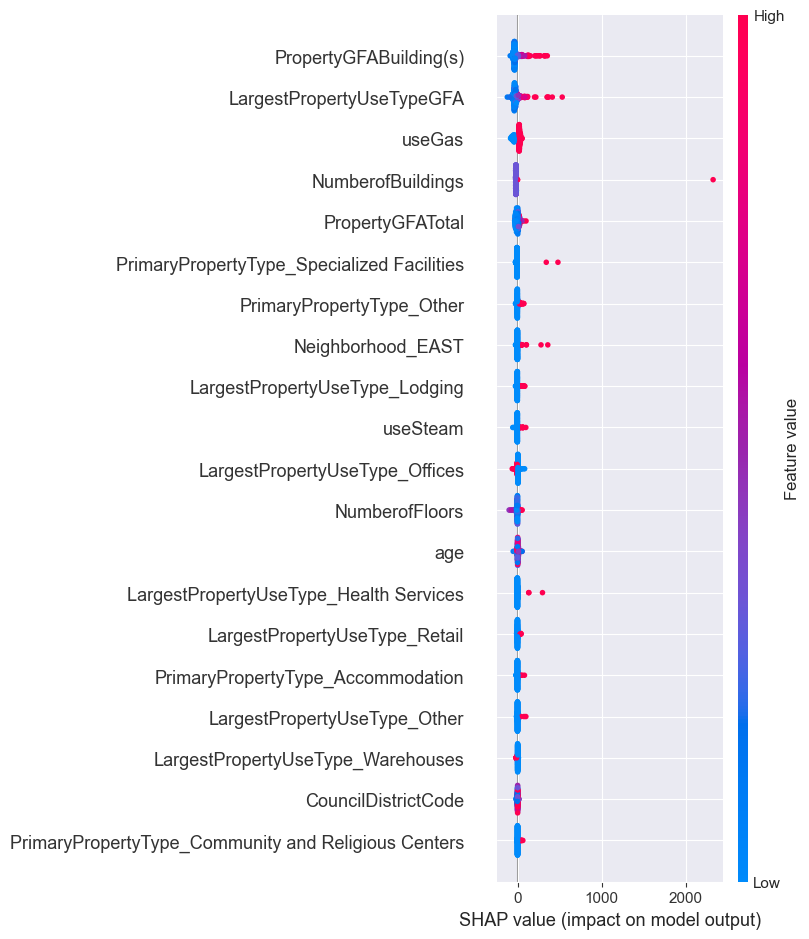

In [67]:
explainer = shap.TreeExplainer(best_rf_model)

shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)

<Axes: >

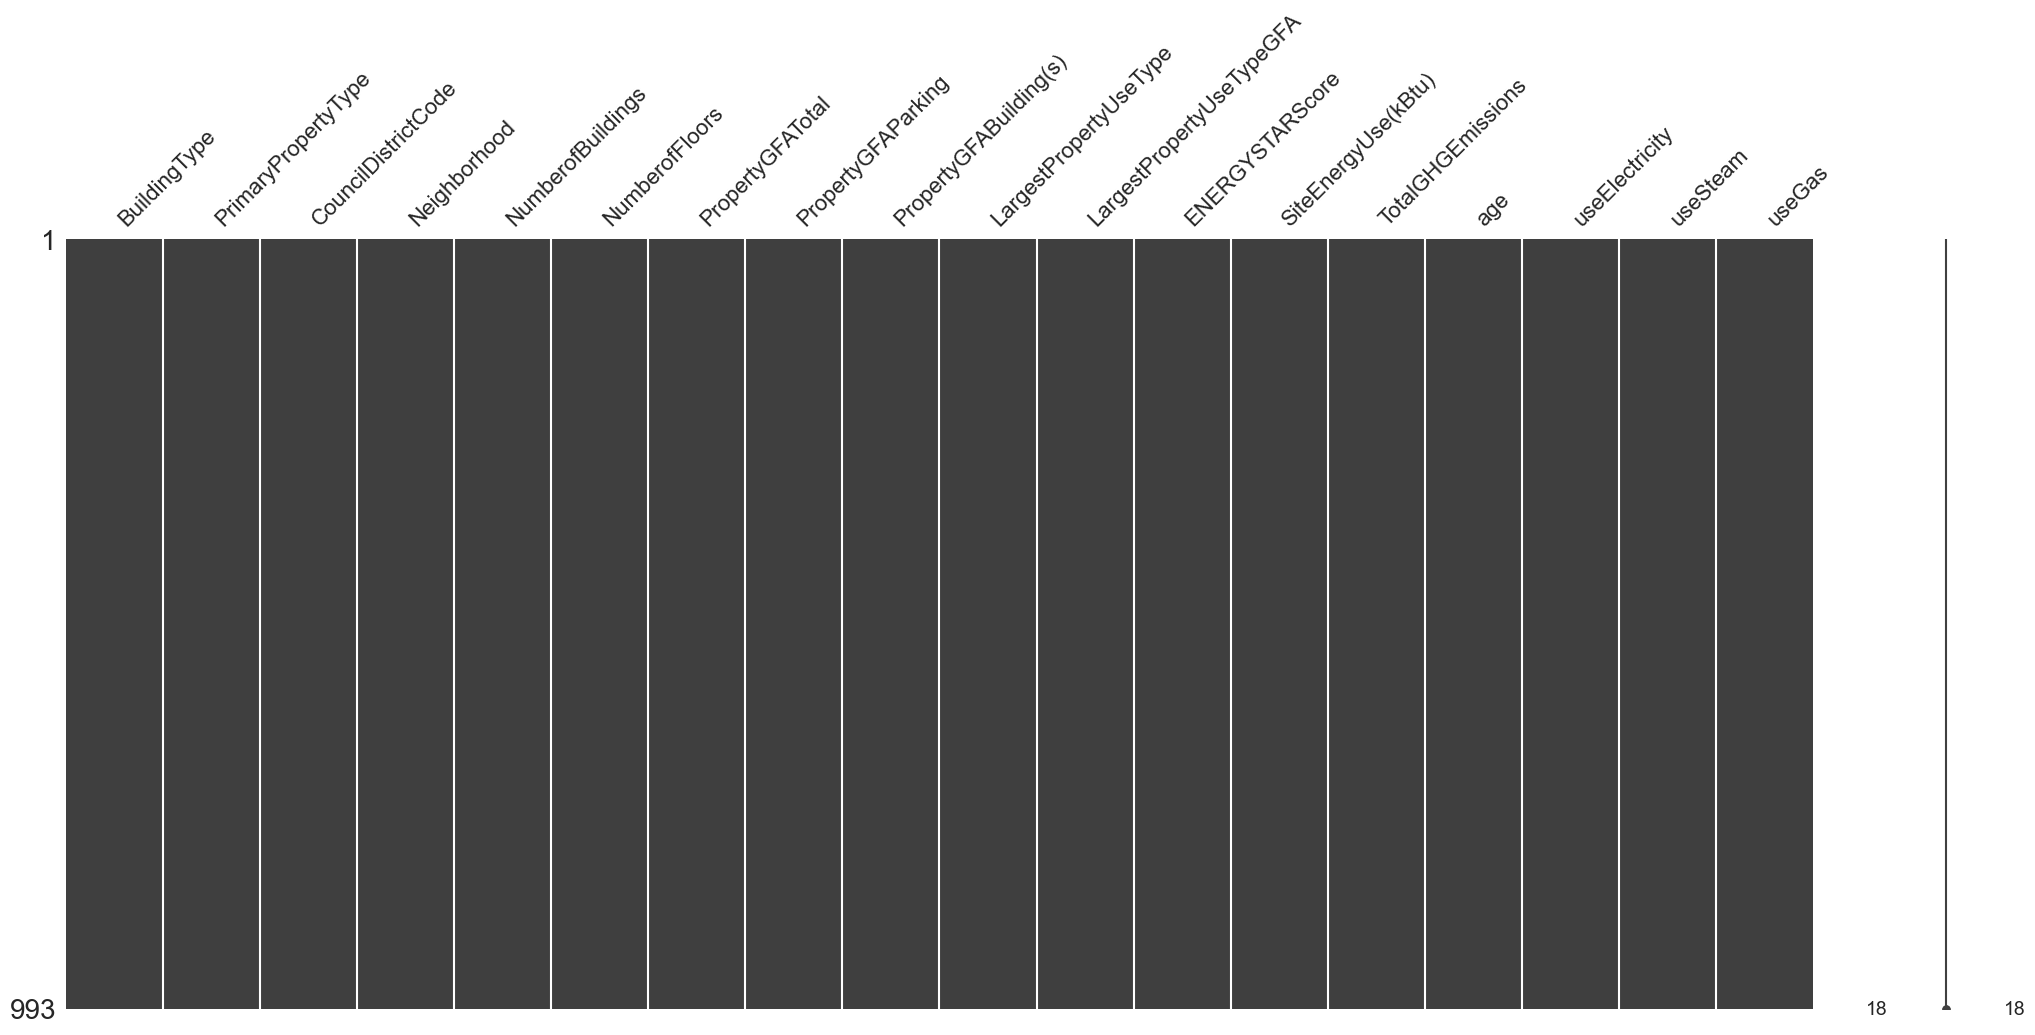

In [68]:
from datetime import datetime
import missingno as msno

EnergyStarScore_data = pd.read_csv('2016_Building_Energy_Benchmarking.csv')
EnergyStarScore_data.loc[EnergyStarScore_data['NumberofFloors'] == 99, 'NumberofFloors'] = 1
EnergyStarScore_data = EnergyStarScore_data.loc[EnergyStarScore_data['BuildingType'] == 'NonResidential']

EnergyStarScore_data = EnergyStarScore_data[EnergyStarScore_data['ENERGYSTARScore'].notnull()]

today = datetime.now().year
EnergyStarScore_data['age'] = today - EnergyStarScore_data['YearBuilt']
EnergyStarScore_data['useElectricity'] = (EnergyStarScore_data['Electricity(kWh)'] > 0).astype(int)
EnergyStarScore_data['useSteam'] = (EnergyStarScore_data['SteamUse(kBtu)'] > 0).astype(int)
EnergyStarScore_data['useGas'] = (EnergyStarScore_data['NaturalGas(therms)'] > 0).astype(int)
features_to_drop = ['OSEBuildingID','DataYear','PropertyName','Address','City','State','ZipCode','TaxParcelIdentificationNumber','Latitude','Longitude','YearBuilt','ListOfAllPropertyUseTypes','SiteEUI(kBtu/sf)','SiteEUIWN(kBtu/sf)','SourceEUI(kBtu/sf)','SourceEUIWN(kBtu/sf)',
                    'SiteEnergyUseWN(kBtu)','SteamUse(kBtu)','Electricity(kWh)','Electricity(kBtu)','NaturalGas(therms)','NaturalGas(kBtu)','ComplianceStatus','DefaultData','GHGEmissionsIntensity']
EnergyStarScore_data = EnergyStarScore_data.drop(features_to_drop, axis=1)

EnergyStarScore_data.drop(EnergyStarScore_data.columns[EnergyStarScore_data.isnull().mean()>0.2], axis=1, inplace=True)
EnergyStarScore_data = EnergyStarScore_data.dropna(axis=0, how='any')

def group_categories(row):
    if row['PrimaryPropertyType'] in ['Small- and Mid-Sized Office', 'Large Office', 'Medical Office']:
        return 'Offices'
    elif row['PrimaryPropertyType'] in ['K-12 School', 'University']:
        return 'Education'
    elif row['PrimaryPropertyType'] in ['Retail Store', 'Supermarket / Grocery Store', 'Warehouse', 'Distribution Center',
                                        'Refrigerated Warehouse']:
        return 'Commerce and Distribution'
    elif row['PrimaryPropertyType'] in ['Hotel', 'Senior Care Community', 'Low-Rise Multifamily', 'Residence Hall']:
        return 'Accommodation'
    elif row['PrimaryPropertyType'] in ['Hospital', 'Laboratory']:
        return 'Specialized Facilities'
    elif row['PrimaryPropertyType'] in ['Worship Facility', 'Mixed Use Property']:
        return 'Community and Religious Centers'
    elif row['PrimaryPropertyType'] == 'Restaurant':
        return 'Restaurants'
    elif row['PrimaryPropertyType'] == 'Self-Storage Facility':
        return 'Self-Storage Facility'
    else:
        return 'Other'

EnergyStarScore_data['PrimaryPropertyType'] = EnergyStarScore_data.apply(group_categories, axis=1)


def group_categories(row):
    if row['LargestPropertyUseType'] in ['Office', 'Medical Office', 'Financial Office', 'Bank Branch']:
        return 'Offices'
    elif row['LargestPropertyUseType'] in ['Non-Refrigerated Warehouse', 'Distribution Center',
                                           'Refrigerated Warehouse']:
        return 'Warehouses'
    elif row['LargestPropertyUseType'] in ['Retail Store', 'Supermarket/Grocery Store', 'Strip Mall',
                                           'Wholesale Club/Supercenter']:
        return 'Retail'
    elif row['LargestPropertyUseType'] in ['Hotel', 'Senior Care Community', 'Other - Lodging/Residential']:
        return 'Lodging'
    elif row['LargestPropertyUseType'] in ['Residence Hall/Dormitory', 'Multifamily Housing']:
        return 'Residential & Dormitories'
    elif row['LargestPropertyUseType'] in ['K-12 School', 'College/University', 'Pre-school/Daycare', 'Adult Education',
                                           'Other - Education']:
        return 'Education'
    elif row['LargestPropertyUseType'] in ['Worship Facility', 'Social/Meeting Hall', 'Performing Arts',
                                           'Other - Entertainment/Public Assembly',
                                           'Museum', 'Other - Recreation', 'Courthouse']:
        return 'Community and Entertainment'
    elif row['LargestPropertyUseType'] in ['Restaurant', 'Other - Restaurant/Bar', 'Food Service']:
        return 'Restaurants'
    elif row['LargestPropertyUseType'] in ['Manufacturing/Industrial Plant',
                                           'Repair Services (Vehicle, Shoe, Locksmith, etc)']:
        return 'Industrial'
    elif row['LargestPropertyUseType'] in ['Hospital (General Medical & Surgical)',
                                           'Urgent Care/Clinic/Other Outpatient', 'Other/Specialty Hospital']:
        return 'Health Services'
    elif row['LargestPropertyUseType'] in ['Fitness Center/Health Club/Gym',
                                           'Personal Services (Health/Beauty, Dry Cleaning, etc)', 'Other - Services']:
        return 'Services'
    elif row['LargestPropertyUseType'] == 'Self-Storage Facility':
        return 'Self-Storage Facility'
    else:
        return 'Other'

EnergyStarScore_data['LargestPropertyUseType'] = EnergyStarScore_data.apply(group_categories, axis=1)
msno.matrix(EnergyStarScore_data)

In [69]:
X_energy = EnergyStarScore_data.drop(["TotalGHGEmissions","SiteEnergyUse(kBtu)"], axis=1)
Y_energy = EnergyStarScore_data["TotalGHGEmissions"]
X_energy = X_energy.astype({col: 'int64' for col in X_energy.select_dtypes(include=['int32']).columns})

In [77]:
X_energy = pd.get_dummies(X_energy)

num_cols = X_energy.select_dtypes(include=['float64']).columns
scaler = StandardScaler()
X_energy[num_cols] = scaler.fit_transform(X_energy[num_cols])

test_energy = pd.DataFrame(columns=["Model","MAE","MSE","RMSE","R2 Score"])

In [78]:
X_without_energy = X_energy.drop(columns=["ENERGYSTARScore"])

X_train_with, X_test_with, y_train, y_test = train_test_split(X_energy, Y_energy, test_size=0.2, random_state=42)
X_train_without, X_test_without, _, _ = train_test_split(X_without_energy, Y_energy, test_size=0.2, random_state=42)

rf_with = RandomForestRegressor(**best_params_rf)
rf_without = RandomForestRegressor(**best_params_rf)

model_with = rf_with.fit(X_train_with, y_train)
model_without = rf_without.fit(X_train_without, y_train)

pred_with = model_with.predict(X_test_with)
pred_without = model_without.predict(X_test_without)

mae_rf_test, mse_rf_test, rmse_rf_test, r_squared_rf_test = evaluation(y_test, pred_with)
new_row_rf = {
    "Model": "Random Forest (With)",
    "MAE": mae_rf,
    "MSE": mse_rf,
    "RMSE": rmse_rf,
    "R2 Score": r_squared_rf
}
test_energy = test_energy._append(new_row_rf, ignore_index=True)

mae_rf, mse_rf, rmse_rf, r_squared_rf = evaluation(y_test, pred_without)

new_row_rf = {
    "Model": "Random Forest (Without)",
    "MAE": mae_rf,
    "MSE": mse_rf,
    "RMSE": rmse_rf,
    "R2 Score": r_squared_rf
}
test_energy = test_energy._append(new_row_rf, ignore_index=True)
test_energy

,Model,MAE,MSE,RMSE,R2 Score
0,Random Forest (With),139.970006,247740.760074,497.735633,0.247247
1,Random Forest (Without),131.909196,282453.652801,531.463689,0.141773


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


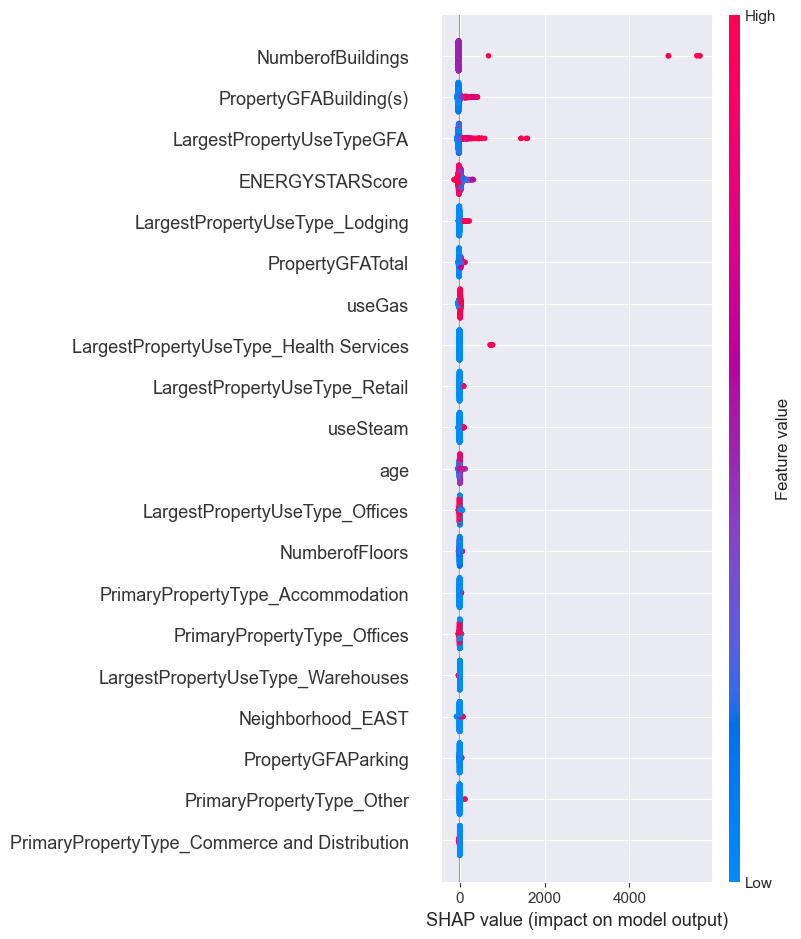

In [79]:
explainer = shap.TreeExplainer(model_with)

shap_values = explainer(X_energy)

shap.summary_plot(shap_values, X_energy)

In [76]:
shap.dependence_plot('ENERGYSTARScore', shap_values, X_energy)

IndexError: index 7 is out of bounds for axis 1 with size 1